# A Simple Neural Net with PyTorch

## Neural Net Definition

In [1]:
# Basic Imports
import torch
import torch.nn as nn

In [2]:
# Method 1
model = nn.Sequential(
    nn.Linear(32 * 32 * 3, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

In [3]:
# Method 2
class SimpleNN(nn.Module):
  def __init__(self):
    super(SimpleNN, self).__init__()
    self.fc1 = nn.Linear(32 * 32 * 3, 128)  # First hidden layer with 128 neurons
    self.fc2 = nn.Linear(128, 64)  # Second hidden layer with 64 neurons
    self.fc3 = nn.Linear(64, 10)  # Output layer with 10 neurons (10 classes in CIFAR-10 dataset)

  def forward(self, x):
    x = x.view(-1, 32 * 32 * 3)  # Flatten the input image to a 1D tensor (-1 used as a placeholder to infer the batch size automatically)
    x = torch.relu(self.fc1(x))  # Apply ReLU Actviation to the first hidden layer
    x = torch.relu(self.fc2(x))  # Apply ReLU Activation to the second hidden layer
    x = self.fc3(x)  # Output layer (no activation function)
    return x


## Load and preprocess CIFAR-10 dataset

In [4]:
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [5]:
# Define a series of image transformations
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        # Normalize pixel values in 3 channels (convert from [0, 255] to [0, 1] to [-1, 1])
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Dataloaders that handle batching, shuffling & parallel data loading for train & test datasets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:01<00:00, 90614969.17it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Define Model, Loss function and Optimizer

In [6]:
# Create an instance of SimpleNN class
model = SimpleNN()

# Cross Entropy Loss for Multi-Class Classification
criterion = nn.CrossEntropyLoss()

# Mini-Batch Stochastic Gradient Descent Optimizer
# model.parameters() -> parameters to be updated
# lr -> learning rate that controls stepsize of weight updates
# momentum -> to accelerate convergence
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Train SimpleNN model for "n" epochs

In [7]:
n_epochs = 5
for epoch in range(n_epochs):
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    inputs, labels = data  # data is a list of [inputs, labels]

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward Pass
    outputs = model(inputs)

    # Loss Calculation
    loss = criterion(outputs, labels)

    # Backpropagation (find gradients)
    loss.backward()

    # Update parameters
    optimizer.step()

    # Extract numerical value of loss
    loss_value = loss.item()

    # Print statistics
    running_loss += loss_value

    if (i + 1) % 2000 == 0:  # Print every 2000 mini-batches
      print(f"Epoch {epoch + 1} Mini-Batch {i + 1:5d} -> Loss = {running_loss / 2000:.3f}")
      running_loss = 0.0

print(f"Finished training for {n_epochs} epochs")

Epoch 1 Mini-Batch  2000 -> Loss = 1.941
Epoch 1 Mini-Batch  4000 -> Loss = 1.748
Epoch 1 Mini-Batch  6000 -> Loss = 1.680
Epoch 1 Mini-Batch  8000 -> Loss = 1.623
Epoch 1 Mini-Batch 10000 -> Loss = 1.582
Epoch 1 Mini-Batch 12000 -> Loss = 1.563
Epoch 2 Mini-Batch  2000 -> Loss = 1.514
Epoch 2 Mini-Batch  4000 -> Loss = 1.476
Epoch 2 Mini-Batch  6000 -> Loss = 1.469
Epoch 2 Mini-Batch  8000 -> Loss = 1.462
Epoch 2 Mini-Batch 10000 -> Loss = 1.459
Epoch 2 Mini-Batch 12000 -> Loss = 1.443
Epoch 3 Mini-Batch  2000 -> Loss = 1.389
Epoch 3 Mini-Batch  4000 -> Loss = 1.367
Epoch 3 Mini-Batch  6000 -> Loss = 1.390
Epoch 3 Mini-Batch  8000 -> Loss = 1.367
Epoch 3 Mini-Batch 10000 -> Loss = 1.394
Epoch 3 Mini-Batch 12000 -> Loss = 1.363
Epoch 4 Mini-Batch  2000 -> Loss = 1.301
Epoch 4 Mini-Batch  4000 -> Loss = 1.327
Epoch 4 Mini-Batch  6000 -> Loss = 1.312
Epoch 4 Mini-Batch  8000 -> Loss = 1.311
Epoch 4 Mini-Batch 10000 -> Loss = 1.315
Epoch 4 Mini-Batch 12000 -> Loss = 1.313
Epoch 5 Mini-Bat

## Metrics

In [8]:
import matplotlib.pyplot as plt

### Accuracy

In [11]:
# Set SimpleNN model to evaluation mode

# Dropout layers drops out (sets to zero) a fraction of the neurons in a layer during each forward pass
# Batch Normalization layers normalize the activations of each layer so that
# they have a mean of zero and a standard deviation of one

# In evaluation mode
# 1- Dropout layers are turned off
# 2- Batch Normalization layers do not compute new batch statistics (mean & standard deviation),
#    instead they use learned statistics from training
model.eval()

# Initialize variables to keep track of correct predictions and total test samples
correct, total = 0, 0

# List to store accuracy values for each batch
accuracy_values = []

# Disable gradient computation for evaluation
with torch.no_grad():
  for batch_num, data in enumerate(testloader, 1):
    images, labels = data

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    n_total_labels = labels.size(0)
    n_correct_labels = (predicted == labels).sum().item()

    total += n_total_labels
    correct += n_correct_labels

    # Calculate accuracy for the current batch
    batch_accuracy = n_correct_labels / n_total_labels

    # Print accuracy every 100 batches
    if batch_num % 100 == 0:
        accuracy = 100 * correct / total
        accuracy_values.append(accuracy)
        print(f'Batch {batch_num}: Accuracy = {accuracy:.2f}%')
    accuracy_values.append(batch_accuracy)

# Calculate the overall accuracy
accuracy = 100 * correct / total
print(f"Accuracy on the test images: {accuracy:.2f}%")


Batch 100: Accuracy = 50.25%
Batch 200: Accuracy = 49.75%
Batch 300: Accuracy = 53.08%
Batch 400: Accuracy = 53.38%
Batch 500: Accuracy = 52.85%
Batch 600: Accuracy = 52.83%
Batch 700: Accuracy = 52.50%
Batch 800: Accuracy = 52.00%
Batch 900: Accuracy = 51.97%
Batch 1000: Accuracy = 52.10%
Batch 1100: Accuracy = 52.30%
Batch 1200: Accuracy = 52.33%
Batch 1300: Accuracy = 52.19%
Batch 1400: Accuracy = 51.79%
Batch 1500: Accuracy = 51.78%
Batch 1600: Accuracy = 51.64%
Batch 1700: Accuracy = 51.65%
Batch 1800: Accuracy = 51.43%
Batch 1900: Accuracy = 51.46%
Batch 2000: Accuracy = 51.33%
Batch 2100: Accuracy = 51.20%
Batch 2200: Accuracy = 51.23%
Batch 2300: Accuracy = 51.25%
Batch 2400: Accuracy = 51.19%
Batch 2500: Accuracy = 51.04%
Accuracy on the test images: 51.04%


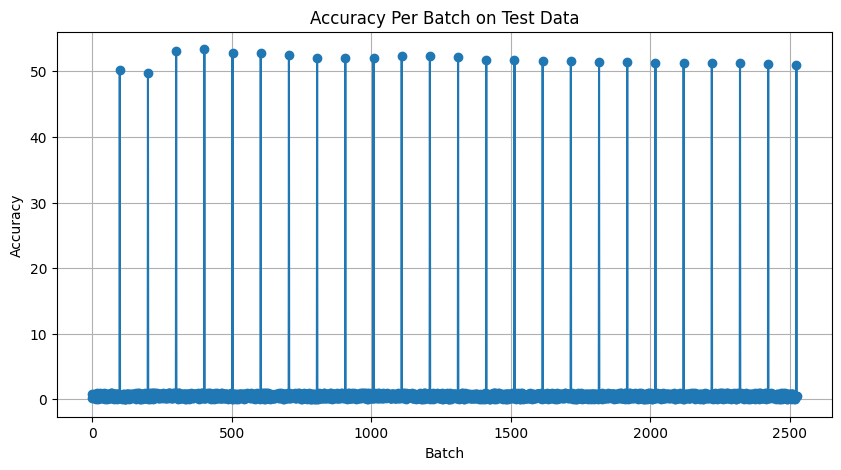

In [12]:
# Plot the accuracy values for every 100 batches
plt.figure(figsize=(10, 5))
plt.plot(accuracy_values, marker='o', linestyle='-')
plt.title('Accuracy Per Batch on Test Data')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()